In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # MNIST 데이터셋을 이미지라서 데이터프레임이랑 잘 안 맞음.

In [2]:
X, y = mnist.data, mnist.target

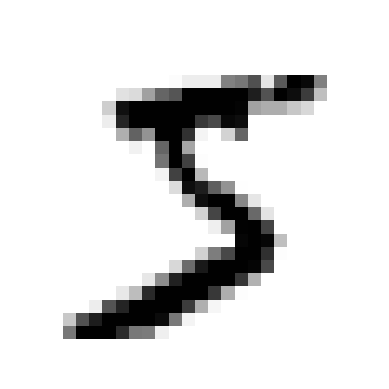

5


In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print(y[0])

In [4]:
# 데이터 조사 전에는 테스트 세트 만들고 떼어놓아야 한다.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
y_train_5 = (y_train == '5')  # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # 데이터 안 섞었으면, shuffle=True 추가

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [9]:
# 더미 분류기
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [10]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [11]:
# 오차 행렬
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

In [13]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [14]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [15]:
# 정밀도와 재현율
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (1891 + 3530)

0.8370879772350012
0.6511713705958311


In [16]:
# F_1 점수 호출
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [17]:
# 임곗값 정해 예측을 만들자.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [19]:
# 적절한 임곗값 정하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
# 정밀도가 최소 90% 되는 가장 낮은 임곗값 찾기
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision # 최댓값의 첫 번째 인덱스 반환, 여기서는 첫 번째 True 값 의미.

3370.0194991439557

In [22]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [23]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

recall_at_90_precision

0.4799852425751706

In [24]:
# ROC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [27]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [28]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train_5가 아닌 y_train을 사용한다.

SVC(random_state=42)

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2) # 가장 높은 점수 9.3, 클래스 5에 해당한다.

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [31]:
class_id = some_digit_scores.argmax()
class_id

5

In [32]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [33]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [34]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 레이블에 클래스의 지지도(타깃 레이블에 속한 샘플 수)를 가중치로 주는 것이 간단한 방법.
# f1_score() 호출할 때 average="weighted"로 설정하면 된다.

0.9764102655606048

In [35]:
# 교차 검증 전략 사용해 ClassifierChain 만들고 훈련
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [36]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mode = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

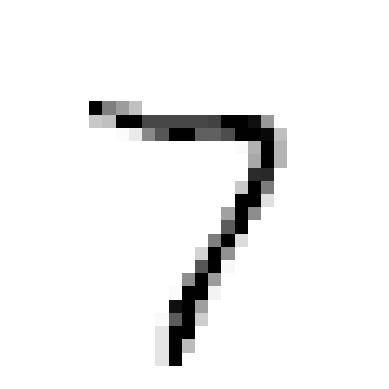

In [38]:
# 깨끗하게 이미지 정리
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mode[0]])
plot_digit(clean_digit)
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV

# KNN 모델 초기화
knn_clf = KNeighborsClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # 다양한 k 값
    'weights': ['uniform', 'distance']  # 가중치 선택
}

In [40]:
# 그리드 서치 초기화
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 점수 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최고 정확도:", grid_search.best_score_)

최적의 하이퍼파라미터: {'n_neighbors': 3, 'weights': 'distance'}
최고 정확도: 0.9693333333333333


테스트 데이터 정확도: 0.9717


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49707 (\N{HANGUL SYLLABLE SUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


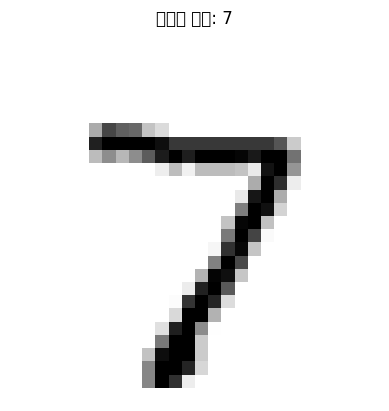

In [43]:
from sklearn.metrics import accuracy_score  # accuracy_score 임포트 추가

# 최적 모델로 테스트 데이터에 대한 예측 수행
best_knn_clf = grid_search.best_estimator_
y_test_pred = best_knn_clf.predict(X_test)

# 테스트 데이터 정확도 평가
accuracy = accuracy_score(y_test, y_test_pred)
print(f"테스트 데이터 정확도: {accuracy:.4f}")

# 예측 결과 시각화 (첫 번째 테스트 데이터)
plot_digit(X_test[0])
plt.title(f"예측된 숫자: {y_test_pred[0]}")
plt.show()